# Make a time series model

In [1]:
import os
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt
from glob import glob

ps.set_log_level("ERROR")
%matplotlib inline

## Read precipitation and evaporation time series

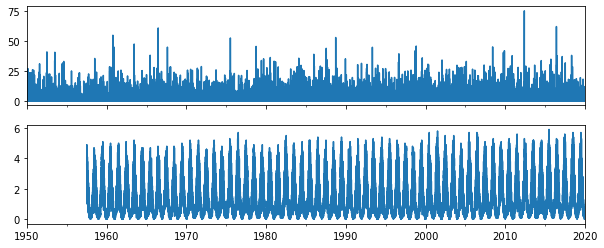

In [2]:
prec = ps.read_knmi("../meteo/precipitation_st_anthonis.txt", variables="RD").series * 1e3
prec = prec.asfreq("D").fillna(0.0)
evap = ps.read_knmi("../meteo/etmgeg_260.txt", variables="EV24").series * 1e3
evap = evap.asfreq("D").fillna(0.0)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
prec.plot(ax=ax1)
evap.plot(ax=ax2);
plt.xlim("1950", "2020");

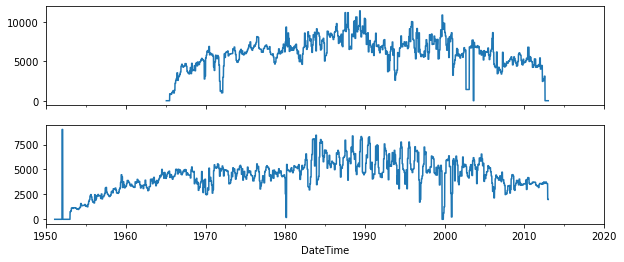

In [3]:
gwa_bm = pd.read_csv("../gw_pumping/abstraction_boxmeer_daily.csv", index_col=0, parse_dates=True, squeeze=True)
gwa_vb = pd.read_csv("../gw_pumping/abstraction_vierlingsbeek_daily.csv", index_col=0, parse_dates=True, squeeze=True)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
gwa_vb.plot(ax=ax1)
gwa_bm.plot(ax=ax2);
plt.xlim("1950", "2020");

# Read GWL

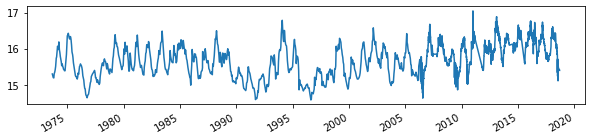

In [4]:
head = ps.read_dino("../gw_levels/raw_gwl/B46D0731001_1.csv")
head.plot(figsize=(10,2));

## Make Pastas Model

Fit report Observations            Fit Statistics
nfev    37                     EVP           60.75
nobs    4598                   R2             0.61
noise   0                      RMSE           0.25
tmin    1973-08-28 00:00:00    AIC        26039.56
tmax    2018-09-14 00:00:00    BIC        26084.60
freq    D                      Obj          143.60
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (7 optimized)
               optimal  stderr     initial   vary
rch_A         1.034971  ±2.63%    0.798282   True
rch_a       192.215285  ±2.61%   10.000000   True
rch_srmax    80.455639  ±6.18%  250.000000   True
rch_lp        0.250000   ±nan%    0.250000  False
rch_ks       91.439870  ±5.08%  100.000000   True
rch_gamma     3.602786  ±7.73%    4.000000   True
rch_simax     2.000000   ±nan%    2.000000  False
rch_kv        1.199283  ±5.70%    1.000000   True
constant_d   14.692167  ±0.27%   15.907175   True


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['RD 905', 'EV24 260']"}>,
 <AxesSubplot:xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=7)'}>]

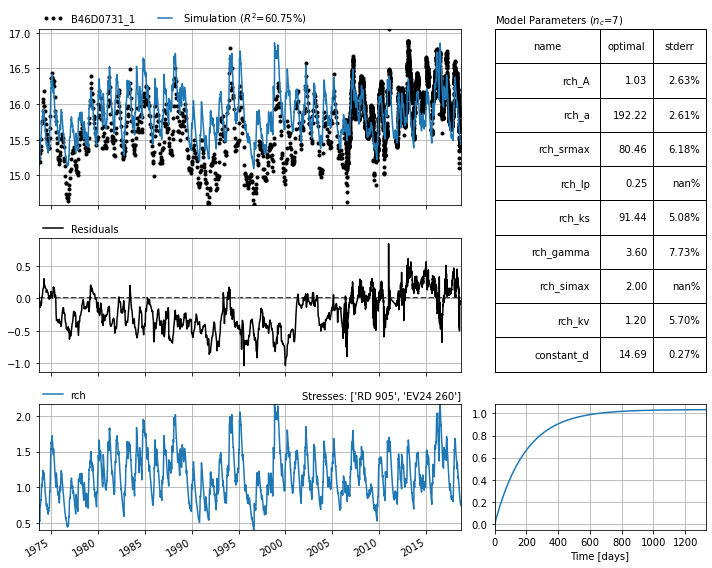

In [5]:
ml = ps.Model(head, name="B52B0389")

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential, name="rch", recharge=ps.rch.FlexModel())
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma, name="Boxmeer", up=False, settings="well")
ml.add_stressmodel([sm1])
ml.set_parameter("rch_kv", vary=True)
ml.solve(tmin="1965", noise=False)
ml.plots.results()

In [6]:
# Create folder to save the model figures
mls = {}
mlpath = "models"
if not os.path.exists(mlpath):
    os.mkdir(mlpath)

# Choose the calibration period
tmin = "1970"
tmax = "2017-09"
num = 0

fnames = glob("../gw_levels/raw_gwl/*.csv")


for fname in fnames:
    head = ps.read_dino(fname)
    name = head.name
    if head.series.loc[tmin:tmax].index.size > 100:
        # Create a Model for each time series and add a StressModel2 for the recharge
        ml = ps.Model(head, name=name)

        # Add the RechargeModel to simulate the effect of rainfall and evaporation
        rm = ps.RechargeModel(prec, evap, rfunc=ps.Gamma, name="recharge")
        ml.add_stressmodel(rm)

        # Add a StressModel to simulate the effect of the groundwater extractions
        sm = ps.StressModel(gwa_bm / 1e6, rfunc=ps.Gamma, name="well", settings="well", up=False)
        ml.add_stressmodel(sm)

        # Estimate the model parameters
        ml.solve(tmin=tmin, tmax=tmax, report=False, solver=ps.LmfitSolve)

        # Check if the estimated effect of the groundwater extraction is significant.
        # If not, delete the stressmodel and calibrate the model again.
    #     gain, stderr = ml.parameters.loc["well_A", ["optimal", "stderr"]]
    #     if stderr is None:
    #         stderr = 10
    #     if 1.96 * stderr > -gain:
    #         num += 1
    #         ml.del_stressmodel("well")
    #         ml.solve(tmin=tmin, tmax=tmax, report=False)

        # Plot the results and store the plot
        mls[name] = ml
        ml.plots.results()
        path = os.path.join(mlpath, name + ".png")
        plt.savefig(path, bbox_inches="tight")
        plt.close()
    
print(f"The number of models where the well is dropped from the model is {num}")

The number of models where the well is dropped from the model is 0


In [7]:
fnames

['../gw_levels/raw_gwl/B52B0411001_1.csv',
 '../gw_levels/raw_gwl/B46C0257001_1.csv',
 '../gw_levels/raw_gwl/B46C0256001_1.csv',
 '../gw_levels/raw_gwl/B46D0791001_1.csv',
 '../gw_levels/raw_gwl/B46D0790001_1.csv',
 '../gw_levels/raw_gwl/B46D0826001_1.csv',
 '../gw_levels/raw_gwl/B46D0827001_1.csv',
 '../gw_levels/raw_gwl/B46D0982001_1.csv',
 '../gw_levels/raw_gwl/B46D0983001_1.csv',
 '../gw_levels/raw_gwl/B46D0818001_1.csv',
 '../gw_levels/raw_gwl/B46D0819001_1.csv',
 '../gw_levels/raw_gwl/B46D0328001_1.csv',
 '../gw_levels/raw_gwl/B46D0329001_1.csv',
 '../gw_levels/raw_gwl/B46D1481001_1.csv',
 '../gw_levels/raw_gwl/B46D0740001_1.csv',
 '../gw_levels/raw_gwl/B46D0741001_1.csv',
 '../gw_levels/raw_gwl/B46D0328003_1.csv',
 '../gw_levels/raw_gwl/B46D0329003_1.csv',
 '../gw_levels/raw_gwl/B46D1028002_1.csv',
 '../gw_levels/raw_gwl/B46D0354001_1.csv',
 '../gw_levels/raw_gwl/B46D1553001_1.csv',
 '../gw_levels/raw_gwl/B46D1552001_1.csv',
 '../gw_levels/raw_gwl/B46D1007001_1.csv',
 '../gw_lev